In [0]:
# !pip3 install -U -q albumentations
# !pip3 install -U -q catalyst
# !pip3 install -U -q PyDrive
# !pip3 install -U -q safitty

In [0]:
!nvidia-smi

Thu Mar 12 07:45:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# #  zip files and upload them
# from google.colab import files
# uploaded = files.upload()

# !unzip unet_plus_attention.zip &> /dev/null
# !rm unet_plus_attention.zip

In [0]:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# link = 'https://drive.google.com/open?id=1mRUSnaKjJwuATemYe9IN1QHAz9sPZpeT'
# fluff, id = link.split('=')
# print (id) # Verify that you have everything after '='
# downloaded = drive.CreateFile({'id':id}) 
# downloaded.GetContentFile('masks.zip')

# link = 'https://drive.google.com/open?id=1Fnzwq4In4o817PN4F1Aeefyv6DII9iUS'
# fluff, id = link.split('=')
# print (id) # Verify that you have everything after '='
# downloaded = drive.CreateFile({'id':id}) 
# downloaded.GetContentFile('train.zip')

# !unzip masks.zip &> /dev/null
# !unzip train.zip &> /dev/null

# !rm train.zip
# !rm masks.zip

In [0]:
from unet_plus_attention.model import *
from unet_plus_attention.metrics import eval_iou
from unet_plus_attention.trainer import train
from unet_plus_attention.dataset import CarvanaDataset

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import gc
import numpy as np
import os

from sklearn.model_selection import train_test_split

alchemy not available, to install alchemy, run `pip install alchemy-catalyst`.
alchemy not available, to install alchemy, run `pip install alchemy-catalyst`.


In [0]:
batch_size = 2
num_epochs = 10
lr = 1e-3
step_size = 3
gamma = 0.2

random_state = 42
test_size = 0.2

images_root = 'train'
masks_root = 'train_masks'

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

criterion = torch.nn.CrossEntropyLoss(weight=torch.Tensor([1.,2.]))
criterion.to(device)

CrossEntropyLoss()

In [0]:
model3 = get_unet_attention_with_skip_connections_decoder(3, 2)
model2 = get_unet_depthwise_encoder_attention_with_skip_connections_decoder(3, 2)
model1 = get_unet_depthwise_light_encoder_attention_with_skip_connections_decoder(3, 2)

In [0]:
summary(model1.to(device), (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 512, 512]              30
              ReLU-2          [-1, 3, 512, 512]               0
       BatchNorm2d-3          [-1, 3, 512, 512]               6
            Conv2d-4         [-1, 64, 512, 512]             256
DepthWiseSeparableConv-5         [-1, 64, 512, 512]               0
            Conv2d-6         [-1, 64, 256, 256]             640
              ReLU-7         [-1, 64, 256, 256]               0
       BatchNorm2d-8         [-1, 64, 256, 256]             128
            Conv2d-9        [-1, 128, 256, 256]           8,320
DepthWiseSeparableConv-10        [-1, 128, 256, 256]               0
           Conv2d-11        [-1, 128, 128, 128]           1,280
             ReLU-12        [-1, 128, 128, 128]               0
      BatchNorm2d-13        [-1, 128, 128, 128]             256
           Conv2d-14        [-

In [0]:
summary(model2.to(device), (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 512, 512]              30
              ReLU-2          [-1, 3, 512, 512]               0
       BatchNorm2d-3          [-1, 3, 512, 512]               6
            Conv2d-4         [-1, 64, 512, 512]             256
DepthWiseSeparableConv-5         [-1, 64, 512, 512]               0
              ReLU-6         [-1, 64, 512, 512]               0
       BatchNorm2d-7         [-1, 64, 512, 512]             128
            Conv2d-8         [-1, 64, 512, 512]             640
              ReLU-9         [-1, 64, 512, 512]               0
      BatchNorm2d-10         [-1, 64, 512, 512]             128
           Conv2d-11         [-1, 64, 512, 512]           4,160
DepthWiseSeparableConv-12         [-1, 64, 512, 512]               0
             ReLU-13         [-1, 64, 512, 512]               0
      BatchNorm2d-14         [

In [0]:
summary(model3.to(device), (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
            Conv2d-4         [-1, 64, 512, 512]          36,928
       BatchNorm2d-5         [-1, 64, 512, 512]             128
              ReLU-6         [-1, 64, 512, 512]               0
            Conv2d-7        [-1, 128, 256, 256]          73,856
       BatchNorm2d-8        [-1, 128, 256, 256]             256
              ReLU-9        [-1, 128, 256, 256]               0
           Conv2d-10        [-1, 128, 256, 256]         147,584
      BatchNorm2d-11        [-1, 128, 256, 256]             256
             ReLU-12        [-1, 128, 256, 256]               0
           Conv2d-13        [-1, 256, 128, 128]         295,168
      BatchNorm2d-14        [-1, 256, 1

In [0]:
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

Thu Mar 12 07:45:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    38W / 250W |    885MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%matplotlib inline

In [0]:
data_limitations = 0.2

def get_dataloaders(data_limitations):
    global images_root
    names = list(map(lambda x: x.rsplit('.', 1)[0], os.listdir(images_root)))
    train_names, val_names = train_test_split(names, random_state=random_state, test_size=test_size)
    np.random.shuffle(train_names)
    np.random.shuffle(val_names)
    train_names = train_names[:int(len(train_names) * data_limitations)]
    val_names = val_names[:int(len(val_names) * data_limitations)]

    print(f"Train: {len(train_names)}\nVal: {len(val_names)}")
    train_dataset = CarvanaDataset(train_names, images_root, masks_root)
    val_dataset = CarvanaDataset(val_names, images_root, masks_root)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    return train_dataloader, val_dataloader


train_dataloader, val_dataloader = get_dataloaders(data_limitations)

Train: 814
Val: 203


### Unet 
#### with Self-Attention + SkipConnection decoder
#### DepthWise Separable Convolution (light)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train: 0.02022662289047051
Validation: 0.020786741273660286


No handles with labels found to put in legend.


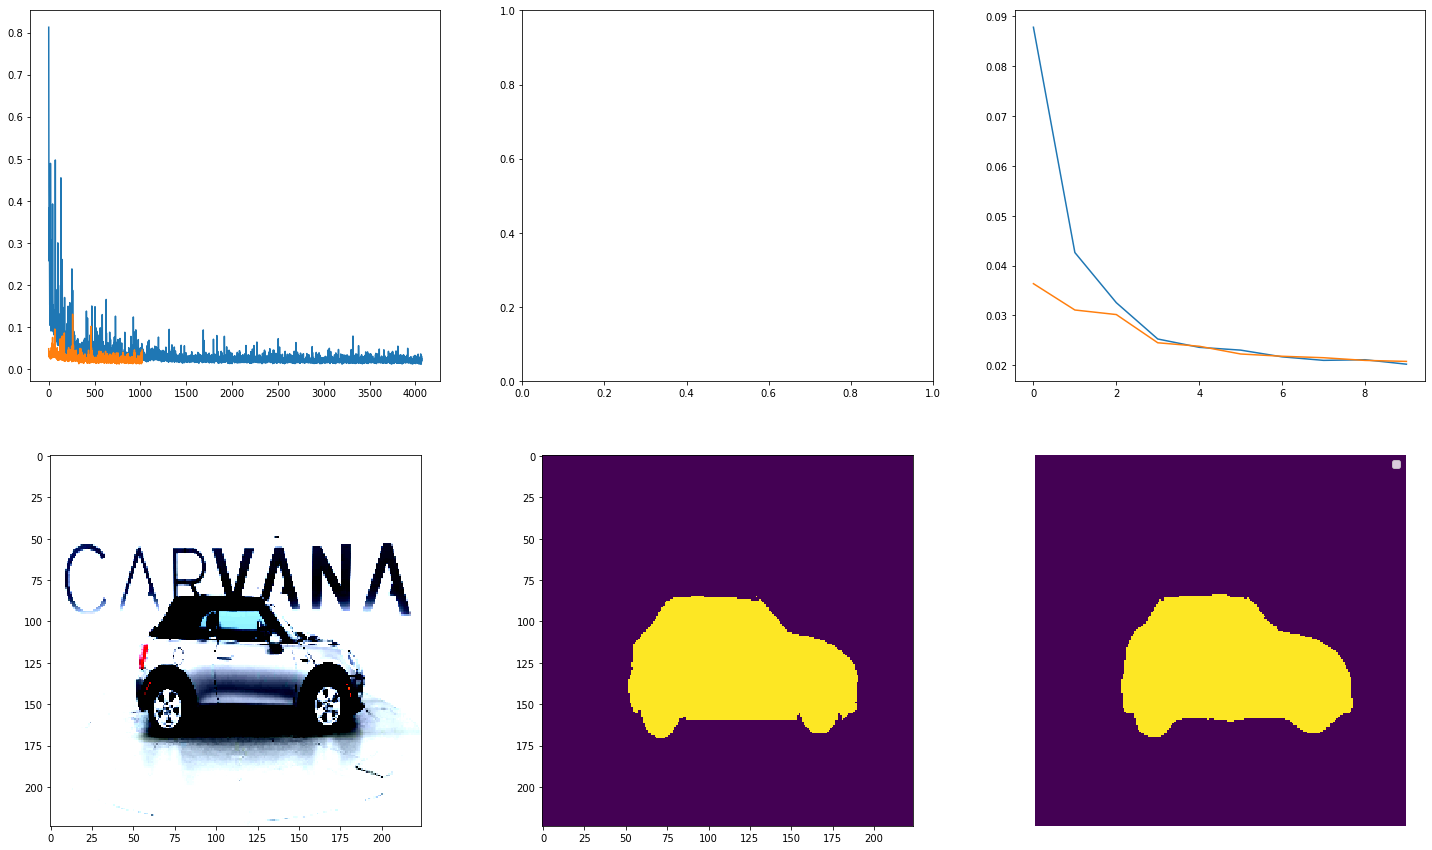

CPU times: user 15min 33s, sys: 10min 30s, total: 26min 3s
Wall time: 25min 52s


In [14]:
%%time

optim = torch.optim.Adam(model1.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size, gamma=gamma)

model1_hist = train(model1, optim, criterion, train_dataloader, val_dataloader, scheduler, device, num_epochs, verbose=True)

In [15]:
model1.load_state_dict(torch.load('best_model.pth'))
score = eval_iou(model1, val_dataloader, device, verbose=False)
print(f"Model IOU score: {score}")

Model IOU score: 0.9712140063444773


### Unet 
#### with Self-Attention + SkipConnection decoder
#### DepthWise Separable Convolution (double)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train: 0.01903212181674614
Validation: 0.02029607702484902


No handles with labels found to put in legend.


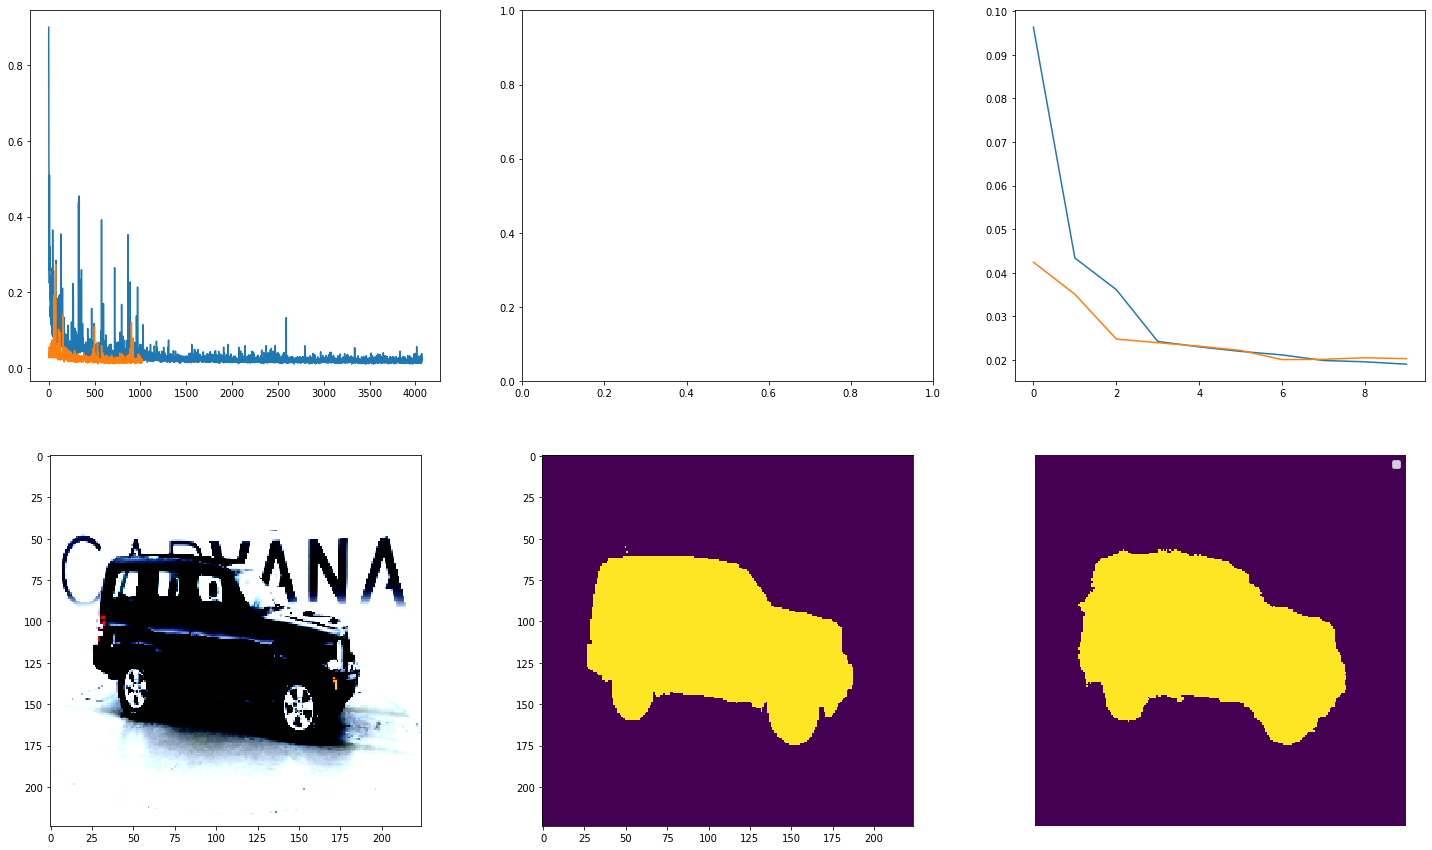

CPU times: user 16min 32s, sys: 11min 27s, total: 27min 59s
Wall time: 27min 49s


In [16]:
%%time

optim = torch.optim.Adam(model2.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size, gamma=gamma)

model2_hist = train(model2, optim, criterion, train_dataloader, val_dataloader, scheduler, device, num_epochs, verbose=True)

In [17]:
model2.load_state_dict(torch.load('best_model.pth'))
score = eval_iou(model2, val_dataloader, device, verbose=False)
print(f"Model IOU score: {score}")

Model IOU score: 0.974154493972367


### Unet 
#### with Self-Attention + SkipConnection decoder
#### Usual convolutions


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train: 0.01939087043028938
Validation: 0.018668802071581867


No handles with labels found to put in legend.


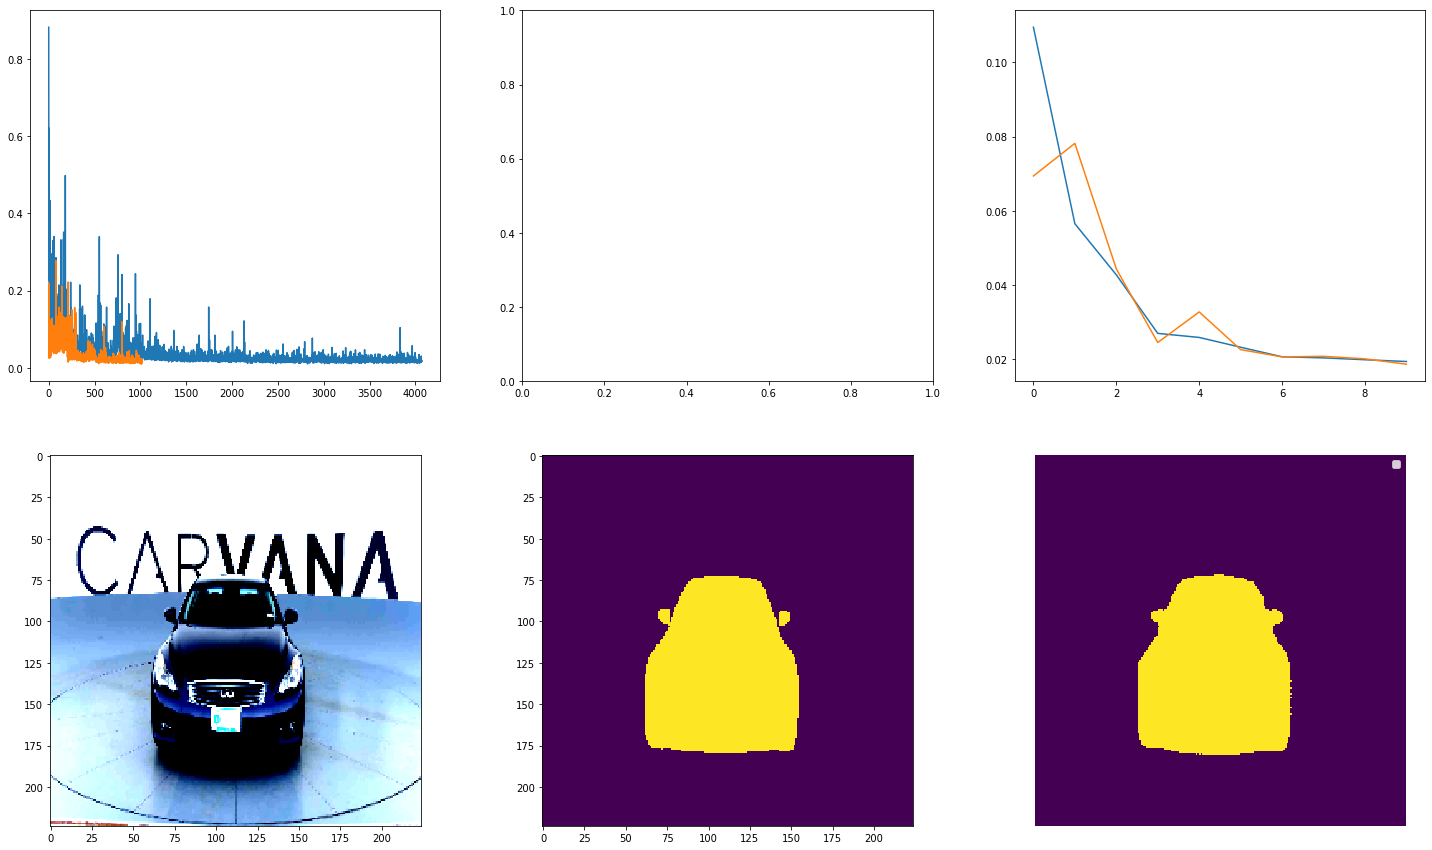

CPU times: user 16min 34s, sys: 10min 14s, total: 26min 49s
Wall time: 26min 36s


In [18]:
%%time

optim = torch.optim.Adam(model3.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size, gamma=gamma)

model3_hist = train(model3, optim, criterion, train_dataloader, val_dataloader, scheduler, device, num_epochs, verbose=True)

In [19]:
model3.load_state_dict(torch.load('best_model.pth'))
score = eval_iou(model3, val_dataloader, device, verbose=False)
print(f"Model IOU score: {score}")

Model IOU score: 0.9747459894301844
